## 基于飞桨实现乒乓球时序动作定位大赛b榜第11名方案

本方案基于数个基线方案和[PaddleVIdeo](https://github.com/PaddlePaddle/PaddleVideo)官方代码仓进行优化

reference:

[使用Paddle实现乒乓球时序动作定位开源方案](https://aistudio.baidu.com/aistudio/projectdetail/3389378)

[使用Football Vocation 分割数据实现乒乓球时序动作定位](https://aistudio.baidu.com/aistudio/projectdetail/3434130)

### 思路：

**数据集的处理**：首先通过观察训练集的label分布，研究了动作的平均时长分布；

之后参考了Football Vocation的处理方法，调整窗口大小；

**训练**：尝试了余弦退火等多种策略，不同的学习率和warmup策略；

尝试了不同的epochs数量。


### 赛题介绍

在众多大规模视频分析情景中，从冗长未经修剪的视频中定位并识别短时间内发生的人体动作成为一个备受关注的课题。当前针对人体动作检测的解决方案在大规模视频集上难以奏效，高效地处理大规模视频数据仍然是计算机视觉领域一个充满挑战的任务。其核心问题可以分为两部分，一是动作识别算法的复杂度仍旧较高，二是缺少能够产生更少视频提案数量的方法（更加关注短时动作本身的提案）。

这里所指的视频动作提案是指一些包含特定动作的候选视频片段。为了能够适应大规模视频分析任务，时序动作提案应该尽可能满足下面两个需求：
（1）更高的处理效率，例如可以设计出使时序视频片段编码和打分更高效的机制；
（2）更强的判别性能，例如可以准确定位动作发生的时间区间。

本次比赛旨在激发更多的开发者和研究人员关注并参与有关视频动作定位的研究，创建性能更出色的动作定位模型。

### 数据集介绍

本次比赛的数据集包含了19-21赛季兵乓球国际比赛（世界杯、世锦赛、亚锦赛，奥运会）和国内比赛（全运会，乒超联赛）中标准单机位高清转播画面的特征信息，共包含912条视频特征文件，每个视频时长在0～6分钟不等，特征维度为2048，以pkl格式保存。我们对特征数据中面朝镜头的运动员的回合内挥拍动作进行了标注，单个动作时常在0～2秒不等，训练数据为729条标注视频，A测数据为91条视频，B测数据为92条视频，训练数据标签以json格式给出。

### 数据集预处理

本方案采用PaddleVideo中的BMN模型。BMN模型是百度自研，2019年ActivityNet夺冠方案，为视频动作定位问题中proposal的生成提供高效的解决方案，在PaddlePaddle上首次开源。此模型引入边界匹配(Boundary-Matching, BM)机制来评估proposal的置信度，按照proposal开始边界的位置及其长度将所有可能存在的proposal组合成一个二维的BM置信度图，图中每个点的数值代表其所对应的proposal的置信度分数。网络由三个模块组成，基础模块作为主干网络处理输入的特征序列，TEM模块预测每一个时序位置属于动作开始、动作结束的概率，PEM模块生成BM置信度图。

本赛题中的数据包含912条ppTSM抽取的视频特征，特征保存为pkl格式，文件名对应视频名称，读取pkl之后以(num_of_frames, 2048)向量形式代表单个视频特征。其中num_of_frames是不固定的，同时数量也比较大，所以pkl的文件并不能直接用于训练。同时由于乒乓球每个动作时间非常短，为了可以让模型更好的识别动作，所以这里将数据进行分割。


1. 首先解压数据集
执行以下命令下载b榜测试集并解压所有数据集，解压之后将压缩包删除，保证项目空间小于100G。否则项目会被终止。

In [1]:
%cd /home/aistudio/data/
!wget https://bj.bcebos.com/v1/ai-studio-online/a34561eb976644e79808072528bf6d8bccb3f8d0b20a4d7499af0db282e01d87 -O Features_competition_test_B.tar.gz

!tar xf Features_competition_test_B.tar.gz
!tar xf data122998/Features_competition_train.tar.gz
!tar xf data123004/Features_competition_test_A.tar.gz
!cp data122998/label_cls14_train.json .
!rm -rf data12*

In [2]:
import os
import sys
import json
import random
import pickle
import numpy as np

2.下面对数据进行一些分析和观察

In [2]:
source_path = "/home/aistudio/data/label_cls14_train.json"

In [4]:
import json
with open('/home/aistudio/data/label_cls14_train.json') as f:
    data = json.load(f)
f.close()

In [5]:
dura = []
for i in range(len(data['gts'])):
    for j in range(len(data['gts'][i]['actions'])):
        # print(i)
        # print(j)
        dura.append(data['gts'][i]['actions'][j]['end_id']-data['gts'][i]['actions'][j]['start_id'])

观察数据的分布，发现平均值为0.74，最大值为33

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline 


df = pd.DataFrame(dura)
df.describe()

,0
count,19054.000000
mean,0.735617
std,0.510685
min,0.040000
25%,0.480000
50%,0.600000
75%,0.840000
max,33.200000


可视化数据分布

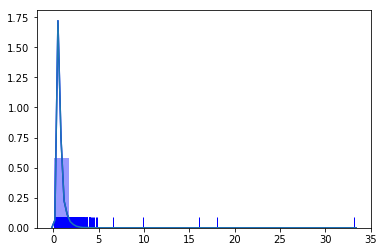

In [7]:
sb.distplot(dura, color="b", bins=20, rug=True)
sb.distplot(dura, hist=False)

去除大于4的数值后的分布

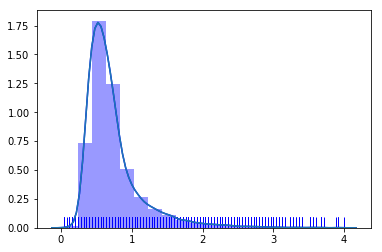

In [8]:
mid  = df.median()
df[(df>4)] = np.nan
df.fillna(mid,inplace=True)
df.describe()
sb.distplot(df, color="b", bins=20, rug=True)
sb.distplot(df, hist=False)

3. 解压好数据之后，首先对label标注文件进行分割。本项目在Baseline的基础上参照[FootballAciton](https://github.com/PaddlePaddle/PaddleVideo/blob/application/FootballAction/datasets/script/get_instance_for_bmn.py)的划分方法，进一步优化训练数据。

In [ ]:
#按照9:1划分训练 测试集
l=len(data['gts'])
l=int(l*0.1)
val = {'gts': data['gts'][0:l], 'fps': 25}
jsonString = json.dumps(val, indent=4, ensure_ascii=False)
jsonFile = open('/home/aistudio/data/label_cls14_val.json', 'w')
jsonFile.write(jsonString)
jsonFile.close()

train = {'gts': data['gts'][l:], 'fps': 25}
jsonString = json.dumps(train, indent=4, ensure_ascii=False)
jsonFile = open('/home/aistudio/data/label_cls14_train.json', 'w')
jsonFile.write(jsonString)
jsonFile.close()

In [ ]:
"""
get instance for bmn
使用winds=4的滑窗，将所有子窗口的长度之和小于winds的进行合并
合并后，父窗口代表bmn训练数据，子窗口代表tsn训练数据
"""
import os
import sys
import json
import random
import pickle
import numpy as np
import math

# for table tennis
bmn_window = 4
dataset = "/home/aistudio/data"
feat_dir = dataset + '/Features_competition_train'
out_dir = dataset + '/Input_for_bmn'
label_files = {
    'train': 'label_cls14_train.json',
    'validation': 'label_cls14_val.json'
}

global fps


def gen_gts_for_bmn(gts_data):
    """
    @param, gts_data, original gts for action detection
    @return, gts_bmn, output gts dict for bmn
    """
    fps = gts_data['fps']
    gts_bmn = {'fps': fps, 'gts': []}
    for sub_item in gts_data['gts']:
        url = sub_item['url']

        max_length = sub_item['total_frames']

        gts_bmn['gts'].append({
            'url': url,
            'total_frames': max_length,
            'root_actions': []
        })
        sub_actions = sub_item['actions']
        # 跳过没有动作的片段
        if len(sub_actions) == 0:
            continue
        # duration > bmn_window， 动作持续时间大于bmn_windows，直接删除
        for idx, sub_action in enumerate(sub_actions):
            if sub_action['end_id'] - sub_action['start_id'] > bmn_window:
                sub_actions.pop(idx)

        # 【滑动窗口，把每一个视频里的动作片段提取出来】
        root_actions = [sub_actions[0]]
        # before_id, 前一动作的最后一帧
        # after_id, 后一动作的第一帧
        before_id = 0
        for idx in range(1, len(sub_actions)):
            cur_action = sub_actions[idx]
            duration = (cur_action['end_id'] - root_actions[0]['start_id'])
            if duration > bmn_window:  # windows只能包住一个动作就包，包不住就包多个
                after_id = cur_action['start_id']
                gts_bmn['gts'][-1]['root_actions'].append({
                    'before_id':
                    before_id,
                    'after_id':
                    after_id,
                    'actions':
                    root_actions
                })
                before_id = root_actions[-1]['end_id']  #更新滑窗
                root_actions = [cur_action]
            else:
                root_actions.append(cur_action)
            if idx == len(sub_actions) - 1:
                after_id = max_length
                gts_bmn['gts'][-1]['root_actions'].append({
                    'before_id':
                    before_id,
                    'after_id':
                    after_id,
                    'actions':
                    root_actions
                })

    return gts_bmn


def combile_gts(gts_bmn, gts_process, mode):
    """
    1、bmn_window 范围内只有一个动作，只取一个目标框
    2、bmn_window 范围内有多个动作，取三个目标框(第一个动作、最后一个动作、所有动作)
    """
    global fps
    fps = gts_process['fps']
    duration_second = bmn_window * 1.0
    duration_frame = bmn_window * fps
    feature_frame = duration_frame
    for item in gts_process['gts']:
        url = item['url']
        basename = os.path.basename(url).split('.')[0]
        root_actions = item['root_actions']
        # 把每一个视频里的动作片段提取出来
        for root_action in root_actions:
            segments = []
            # all actions
            segments.append({
                'actions': root_action['actions'],
                'before_id': root_action['before_id'],
                'after_id': root_action['after_id']
            })
            if len(root_action['actions']) > 1:  #如果有多个动作，则第一个动作和最后一个动作，额外添加一次
                # first action
                segments.append({
                    'actions': [root_action['actions'][0]],
                    'before_id':
                    root_action['before_id'],
                    'after_id':
                    root_action['actions'][1]['start_id']
                })
                # last action
                segments.append({
                    'actions': [root_action['actions'][-1]],
                    'before_id':
                    root_action['actions'][-2]['end_id'],
                    'after_id':
                    root_action['after_id']
                })

            # 把动作片段处理成window size大小，以适配BMN输入
            for segment in segments:
                before_id = segment['before_id']
                after_id = segment['after_id']
                actions = segment['actions']
                # before_id到after_id太长了，从里面取window_size帧，要先确定一个起始点，然后动作都要包住
                box0 = max(actions[-1]['end_id'] - bmn_window,
                           before_id)  #确定起始点
                box1 = min(actions[0]['start_id'],
                           after_id - bmn_window)  #确实起始点
                if box0 <= box1:  # 一次检查
                    if int(box0) - int(box1) == 0:
                        cur_start = box0
                    else:
                        box0 = math.ceil(box0)
                        box1 = int(box1)
                        cur_start = random.randint(box0, box1)
                    cur_end = cur_start + bmn_window
                    cur_start = round(cur_start, 2)
                    cur_end = round(cur_end, 2)
                    name = '{}_{}_{}'.format(basename, cur_start, cur_end)
                    annotations = []
                    for action in actions:
                        label = str(1.0 * action['label_ids'][0])
                        label_name = action['label_names'][0]
                        seg0 = 1.0 * round((action['start_id'] - cur_start),
                                           2)  #存储的是到开始位置(时间: s)的距离
                        seg1 = 1.0 * round((action['end_id'] - cur_start), 2)
                        annotations.append({
                            'segment': [seg0, seg1],
                            'label': label,
                            'label_name': label_name
                        })
                    gts_bmn[name] = {
                        'duration_second': duration_second,
                        'duration_frame': duration_frame,
                        'feature_frame': feature_frame,
                        'subset': mode,
                        'annotations': annotations
                    }

    return gts_bmn


def save_feature_to_numpy(gts_bmn, folder):
    global fps
    print('save feature for bmn ...')
    if not os.path.exists(folder):
        os.mkdir(folder)
    process_gts_bmn = {}
    miss = 0
    for item, value in gts_bmn.items():
        # split to rsplit 针对文件命名修改
        basename, start_id, end_id = item.rsplit('_', 2)
        if not basename in process_gts_bmn:
            process_gts_bmn[basename] = []
        process_gts_bmn[basename].append({
            'name': item,
            'start': float(start_id),
            'end': float(end_id)
        })
    for item, values in process_gts_bmn.items():
        feat_path = os.path.join(feat_dir, item + '.pkl')
        feature_video = pickle.load(open(feat_path, 'rb'))['image_feature']
        for value in values:
            save_cut_name = os.path.join(folder, value['name'])
            a, b, c = save_cut_name.rsplit('_', 2)
            if float(b) > 360:
                print(b)
            start_frame = round(value['start'] * fps)
            end_frame = round(value['end'] * fps)
            if end_frame > len(feature_video):
                miss += 1
                continue
            feature_cut = [
                feature_video[i] for i in range(start_frame, end_frame)
            ]
            np_feature_cut = np.array(feature_cut, dtype=np.float32)
            np.save(save_cut_name, np_feature_cut)

    print('miss number (broken sample):', miss)


if __name__ == "__main__":
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    gts_bmn = {}
    for item, value in label_files.items():
        label_file = os.path.join(dataset, value)
        gts_data = json.load(open(label_file, 'rb'))
        gts_process = gen_gts_for_bmn(gts_data)
        gts_bmn = combile_gts(gts_bmn, gts_process, item)

    with open(out_dir + '/label.json', 'w', encoding='utf-8') as f:
        data = json.dumps(gts_bmn, indent=4, ensure_ascii=False)
        f.write(data)

    save_feature_to_numpy(gts_bmn, out_dir + '/feature')

In [ ]:

import copy
import json
import re
import os

url = '/home/aistudio/data/Input_for_bmn/feature/'
directory = os.fsencode(url)
count = 0
target_set = []

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    target_name = filename.split('.npy')[0]
    target_set.append(target_name)
    count += 1
print('Feature size:', len(target_set))

with open('/home/aistudio/data/Input_for_bmn/label.json') as f:
    data = json.load(f)

delet_set = []
for key in data.keys():
    if not key in target_set:
        delet_set.append(key)

print('(Label) Original size:', len(data))
print('(Label) Deleted size:', len(delet_set))

for item in delet_set:
    data.pop(item, None)

print('(Label) Fixed size:', len(data))

jsonString = json.dumps(data, indent=4, ensure_ascii=False)
jsonFile = open('/home/aistudio/data/Input_for_bmn/label_fixed.json', 'w')
jsonFile.write(jsonString)
jsonFile.close()

执行完毕后，在data/Input_for_bmn/目录中生成了新的标注文件label_fixed.json。同时删除不必要的原始文件，降低空间占用

In [ ]:
!rm /home/aistudio/data/Features_competition_train/*.pkl

执行后在data/Features_competition_train/npy目录下生成了训练用的numpy数据。

In [ ]:
import os
import os.path as osp
import glob
import pickle
import paddle

import numpy as np

file_list = glob.glob("/home/aistudio/data/Features_competition_test_A/*.pkl")

max_frames = 9000

npy_path = ("/home/aistudio/data/Features_competition_test_A/npy/")
if not osp.exists(npy_path):
    os.makedirs(npy_path)

for f in file_list:
    video_feat = pickle.load(open(f, 'rb'))
    tensor = paddle.to_tensor(video_feat['image_feature'])
    pad_num = 9000 - tensor.shape[0]
    pad1d = paddle.nn.Pad1D([0, pad_num])
    tensor = paddle.transpose(tensor, [1, 0])
    tensor = paddle.unsqueeze(tensor, axis=0)
    tensor = pad1d(tensor)
    tensor = paddle.squeeze(tensor, axis=0)
    tensor = paddle.transpose(tensor, [1, 0])

    sps = paddle.split(tensor, num_or_sections=90, axis=0)
    for i, s in enumerate(sps):
        file_name = osp.join(npy_path, f.split('/')[-1].split('.')[0] + f"_{i}.npy")
        np.save(file_name, s.detach().numpy())
    pass

### 训练模型

数据集分割好之后，可以开始训练模型，使用以下命令进行模型训练。首先需要安装PaddleVideo的依赖包。

In [ ]:

# 从Github上下载PaddleVideo代码
!git clone https://github.com/PaddlePaddle/PaddleVideo.git

In [ ]:
%cd /home/aistudio/PaddleVideo/
!pip install -r requirements.txt

开始训练模型

config文件位于/home/aistudio/model/bmn.yaml 

训练时的恢复训练这一参数参考了官方repo，需要在训练时指定 -o参数，同时在config文件中指定resume_from的模型权重位置

训练截图：

![](https://ai-studio-static-online.cdn.bcebos.com/08f6c050f19748a6ace92c6c6e49ce996e9344729b304c6fa98e6ac583101dbf)

最终用于比赛提交的模型权重是第50个，位置是/home/aistudio/model/BMN_epoch_00050.pdparams

训练时采用了不同的batdch_size策略，提升不大

采用了不同的学习率策略：[https://github.com/PaddlePaddle/PaddleVideo/blob/develop/paddlevideo/solver/custom_lr.py](https://github.com/PaddlePaddle/PaddleVideo/blob/develop/paddlevideo/solver/custom_lr.py)

使用CustomWarmupCosineDecay比直接decay的a榜分数提高了0.5左右

In [ ]:
%cd /home/aistudio/PaddleVideo/
#!python main.py -c  configs/localization/bmn.yaml
!python -B main.py  --validate -c  /home/aistudio/model/bmn.yaml -o resume_epoch=45


### 模型导出
将训练好的模型导出用于推理预测，执行以下脚本。

In [ ]:
%cd /home/aistudio/PaddleVideo/
!python tools/export_model.py -c configs/localization/bmn.yaml -p /home/aistudio/model/BMN_epoch_00050.pdparams -o inference/BMN

### 推理预测

使用导出的模型进行推理预测，执行以下命令。

In [ ]:
%cd /home/aistudio/PaddleVideo/
# !python tools/predict.py --input_file /home/aistudio/data/Features_competition_test_A/npy \
!python tools/predict.py --input_file /home/aistudio/data/Features_competition_test_B/npy \
 --config configs/localization/bmn.yaml \
 --model_file inference/BMN/BMN.pdmodel \
 --params_file inference/BMN/BMN.pdiparams \
 --use_gpu=True \
 --use_tensorrt=False

上面程序输出的json文件是分割后的预测结果，还需要将这些文件组合到一起。执行以下脚本：

In [ ]:
import os
import json
import glob

# json_path = "/home/aistudio/data/Features_competition_test_A/npy/"
json_path = "/home/aistudio/data/Features_competition_test_B/npy/"
json_files = glob.glob(os.path.join(json_path, '*_*.json'))

In [ ]:
submit_dic = {"version": None,
              "results": {},
              "external_data": {}
              }
results = submit_dic['results']
for json_file in json_files:
    j = json.load(open(json_file, 'r'))
    old_video_name = list(j.keys())[0]
    video_name = list(j.keys())[0].split('/')[-1].split('.')[0]
    video_name, video_no = video_name.split('_')
    start_id = int(video_no) * 4
    if len(j[old_video_name]) == 0:
        continue
    for i, top in enumerate(j[old_video_name]):
        if video_name in results.keys():
            results[video_name].append({'score': round(top['score'], 2),
                                        'segment': [round(top['segment'][0] + start_id, 2), round(top['segment'][1] + start_id, 2)]})
        else:
            results[video_name] = [{'score':round(top['score'], 2),
                                        'segment': [round(top['segment'][0] + start_id, 2), round(top['segment'][1] + start_id, 2)]}]

json.dump(submit_dic, open('/home/aistudio/submission.json', 'w', encoding='utf-8'))

最后会在用户目录生成submission.json文件，压缩后下载提交即可。

In [ ]:
%cd /home/aistudio/
!zip submission.zip submission.json

/home/aistudio
  adding: submission.json (deflated 91%)


总结：

提升点：

数据处理上：使原始数据更均衡，

网络结构上：可以优化base部分。[https://github.com/PaddlePaddle/PaddleVideo/blob/develop/paddlevideo/modeling/backbones/bmn.py](https://github.com/PaddlePaddle/PaddleVideo/blob/develop/paddlevideo/modeling/backbones/bmn.py)